In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

#### import dataset to our notebook

In [88]:
dataset = pd.read_csv('Ecommerce Customers')
dataset.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


#### Let's find check quality of data and find possible missing data.

In [89]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Email                 500 non-null    object 
 1   Address               500 non-null    object 
 2   Avatar                500 non-null    object 
 3   Avg. Session Length   500 non-null    float64
 4   Time on App           500 non-null    float64
 5   Time on Website       500 non-null    float64
 6   Length of Membership  500 non-null    float64
 7   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


In [90]:
dataset.isna().sum()

Email                   0
Address                 0
Avatar                  0
Avg. Session Length     0
Time on App             0
Time on Website         0
Length of Membership    0
Yearly Amount Spent     0
dtype: int64

#### I'm gonna try extract information from email and address. First change extract user and domain, domain that is not popular will change to others. I have an assumption that it might be some different activity between popular domain and self or company domain.

In [91]:
def split_name(name):
    return pd.Series(name.split("@", 1))

# extract username and domain from email
dataset[['username', 'domain']] = dataset['Email'].apply(split_name)

# detail of domain
#print(dataset['domain'].value_counts())

# change domain that is not popular to others
other_domain = (dataset['domain'] != 'gmail.com') & (dataset['domain'] != 'hotmail.com') & (dataset['domain'] != 'yahoo.com')
dataset.loc[other_domain , "domain"] = 'others'

# clear .com suffix from domain
dataset['domain'] = dataset['domain'].str.replace(".com", "")
print(dataset['domain'].value_counts())

others     250
hotmail     87
gmail       87
yahoo       76
Name: domain, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_16024\2807182362.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['domain'] = dataset['domain'].str.replace(".com", "")


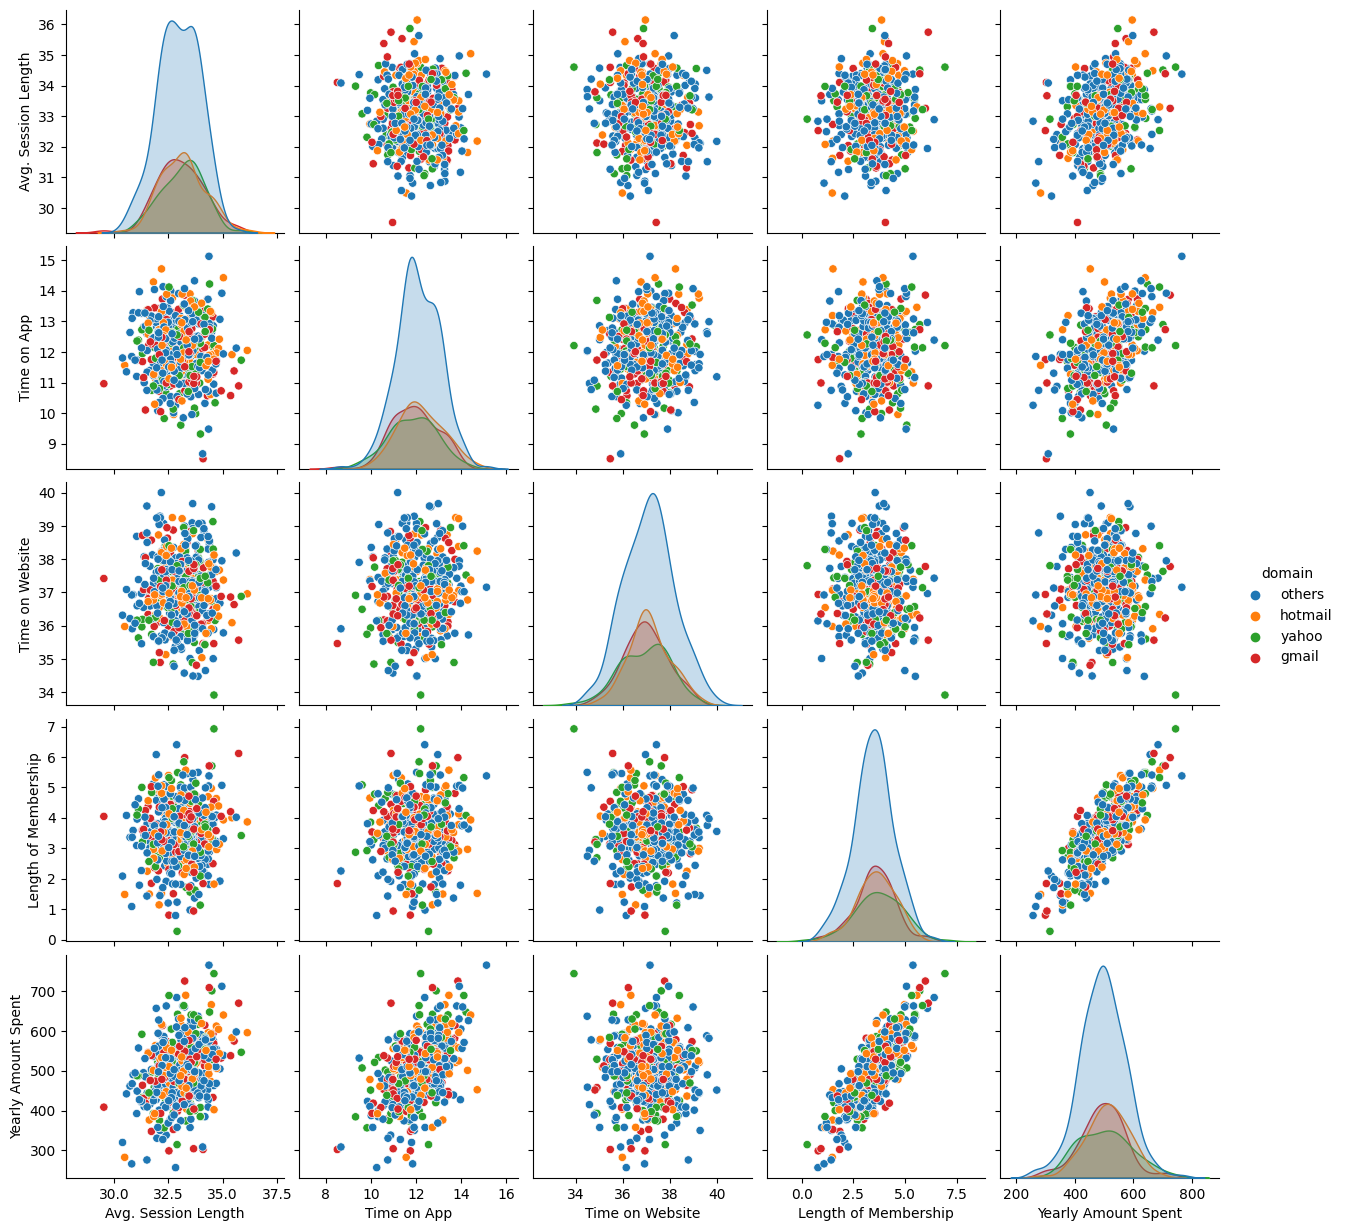

In [92]:
sns.pairplot(dataset, hue='domain')
plt.show()

#### thier is strong relationship between amount spent and time on app, but there is no different between email domain.

C:\Users\User\AppData\Local\Temp\ipykernel_16024\725540657.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset.corr(), cmap="YlGnBu", annot=True)


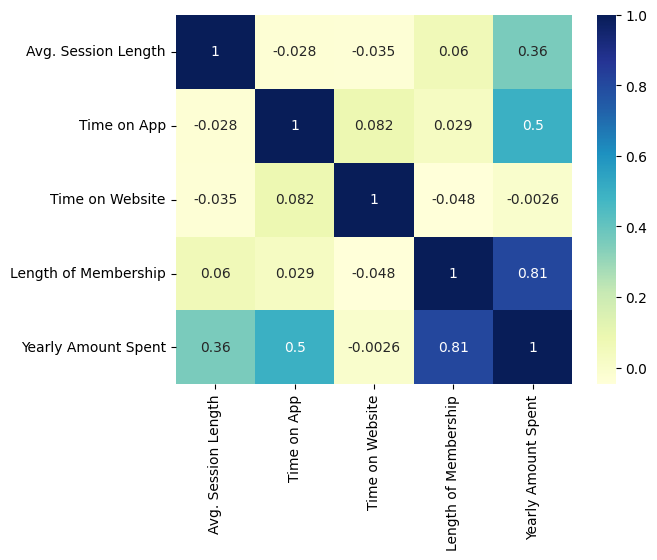

In [93]:
sns.heatmap(dataset.corr(), cmap="YlGnBu", annot=True)
plt.show()

#### let try round Length of Membership to see if there is any insight data

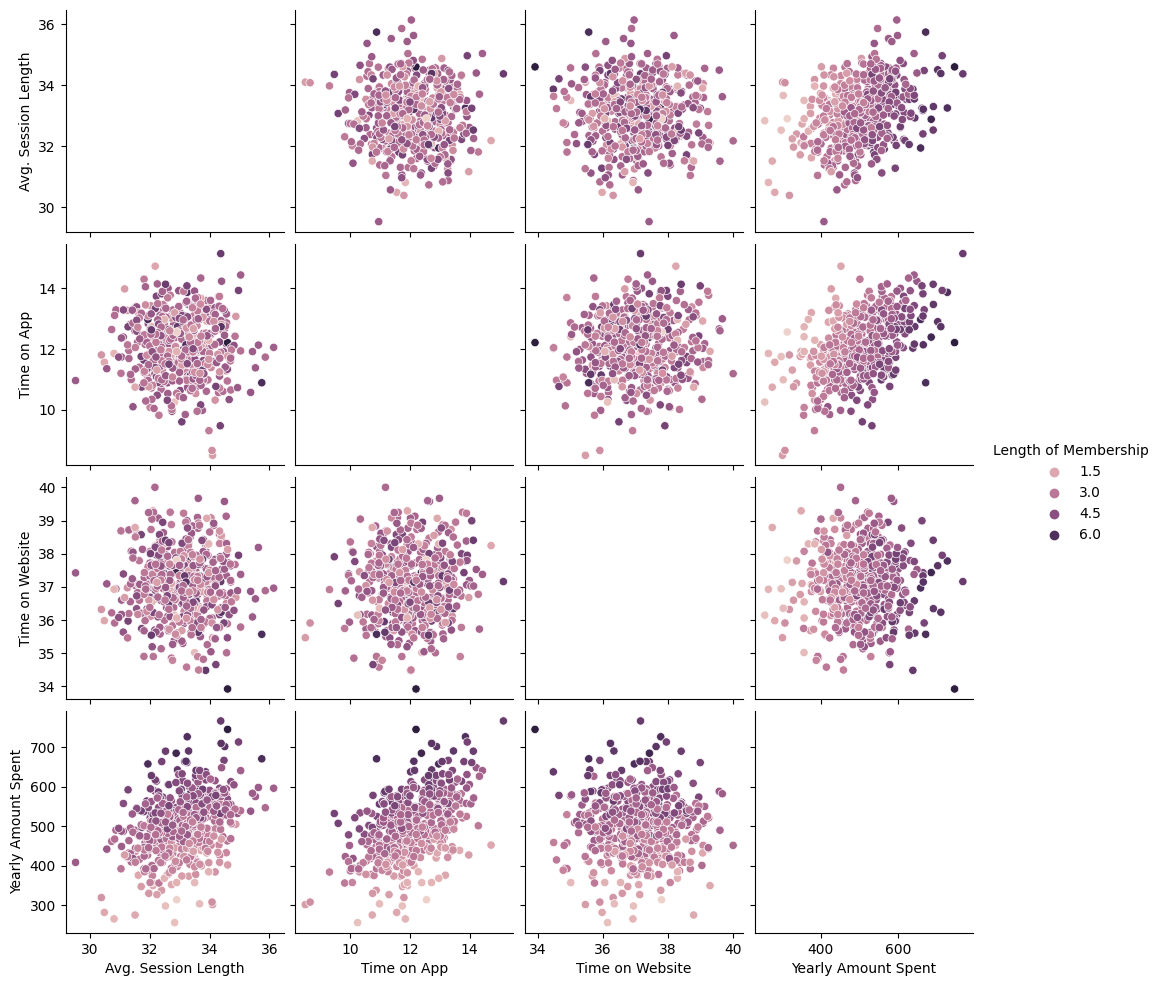

In [116]:
sns.pairplot(dataset, hue='Length of Membership')
plt.show()

#### There is strong relationship between time on app and yearly amount, moreover if length of membership is higher the spent is look tend to be higher.

In [96]:
# Create a figure and axes. Then plot the data
def displot_with_outlier(col):
    fig, ax = plt.subplots()
    ax = sns.histplot(dataset[col], ax=ax,)

    # calculate mean and standard deviation
    avg = dataset[col].mean()
    std = dataset[col].std()

    # Add vertical lines for the median and mean
    ax.axvline(x=avg + 3 * std, color='r', label='upper 3 sigma', linestyle='--', linewidth=2)
    ax.axvline(x=avg - 3 * std, color='r', label='lower 3 sigma', linestyle='--', linewidth=2)

    # calculate iqr
    q1 = dataset[col].quantile(0.25)
    q3 = dataset[col].quantile(0.75)
    iqr = q3 - q1
    ax.axvline(x=q3 + 1.5 * iqr, color='y', label='upper iqr', linestyle='--', linewidth=2)
    ax.axvline(x=q1 - 1.5 * iqr, color='y', label='lower iqr', linestyle='--', linewidth=2)

    # Show the legend and plot the data
    ax.legend()
    plt.title(str(col) + ' distribution')
    plt.show()

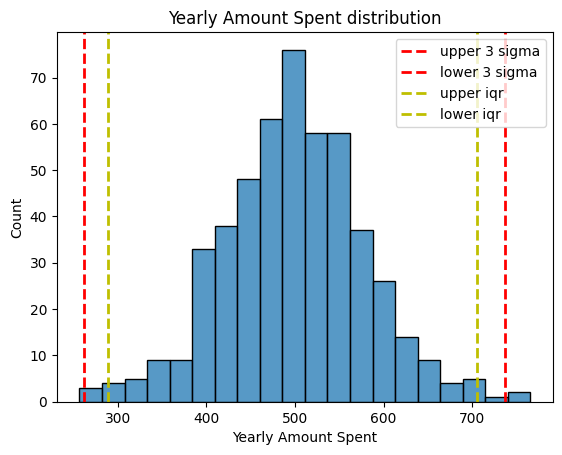

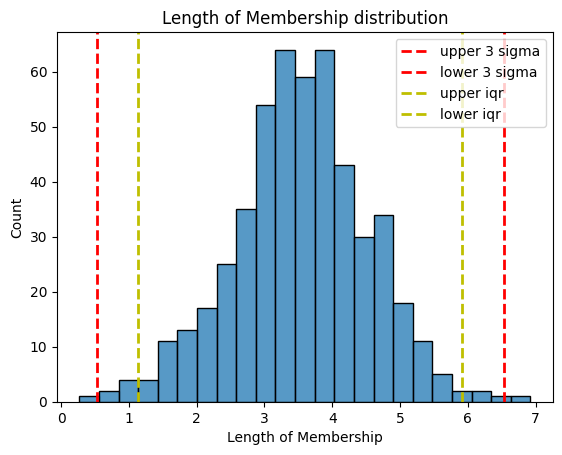

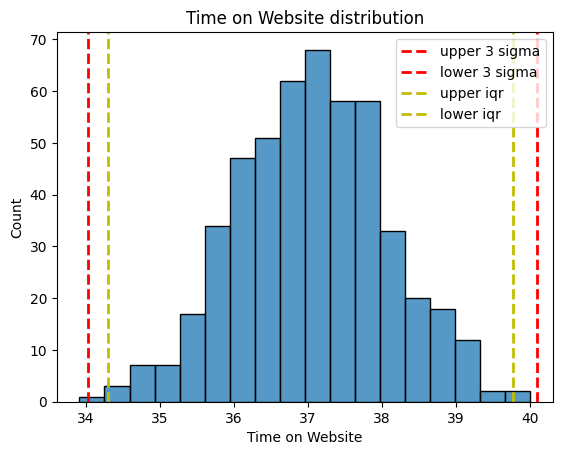

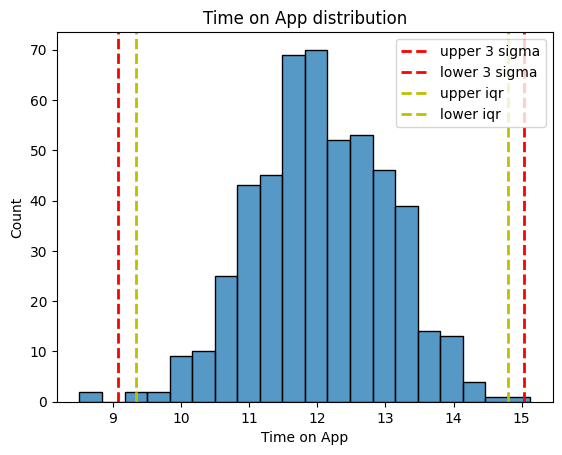

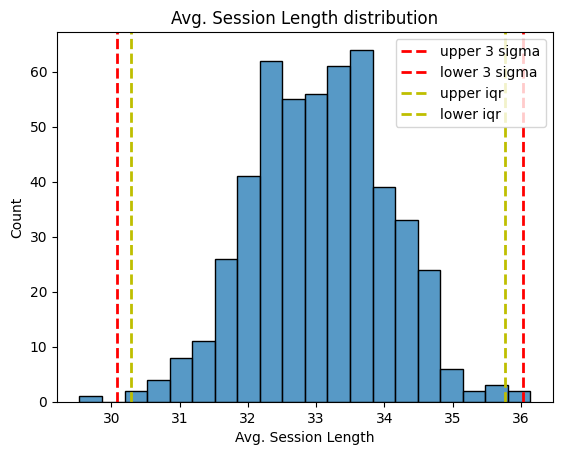

In [97]:
displot_with_outlier('Yearly Amount Spent')
displot_with_outlier('Length of Membership')
displot_with_outlier('Time on Website')
displot_with_outlier('Time on App')
displot_with_outlier('Avg. Session Length')

root mean squared error = 10.193897260863144
r2 score = 0.9808757641125856


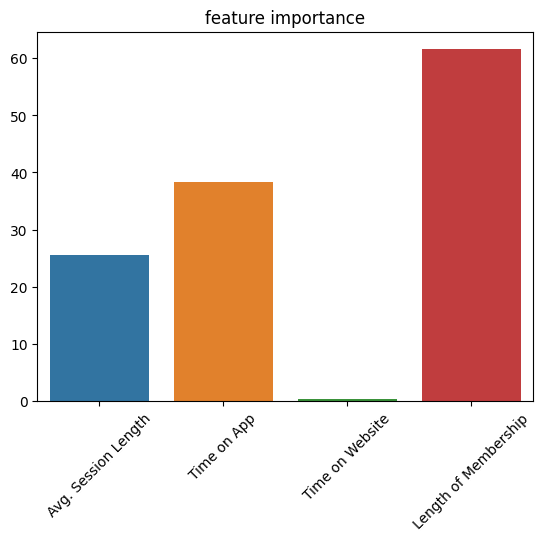

In [110]:
# select only  numeric features
features = ['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']
X = dataset[features]
y= dataset['Yearly Amount Spent']

# define model
linreg = LinearRegression()

# define scaler to scale every feature equaly, by this meethod we can compare feature effect
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# fit model
linreg.fit(X_train, y_train)

# test model
pred = linreg.predict(X_test)
print("root mean squared error =", mean_squared_error(y_test, pred) ** (1/2))
print("r2 score =", r2_score(y_test, pred))

# observe coefficients
sns.barplot(x=features, y=linreg.coef_)
plt.title("feature importance")
plt.xticks(rotation=45)
plt.show()

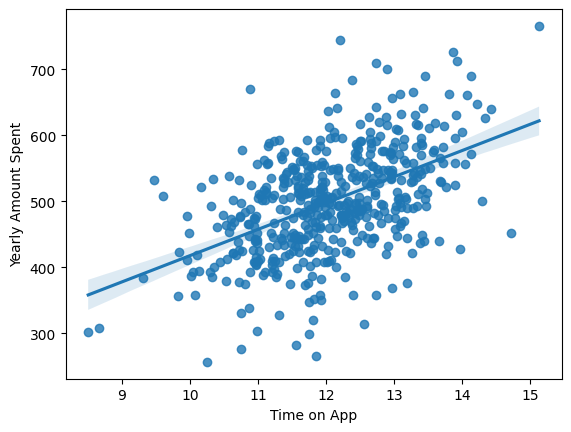

In [113]:
sns.regplot(x=dataset['Time on App'], y=dataset['Yearly Amount Spent'])
plt.show()

#### this clearly anwser the question that time on app has effect on amount spent thant website